<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [ ]:
#| eval: false
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Classifier

In [ ]:
#| eval: false
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [ ]:
#| eval: false
b = xb,yb = next(iter(dls.train))

In [ ]:
#| eval: false
cbs = [DeviceCB(), MixedPrecision()]
model = torch.load('models/data_aug2.pkl')
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=None)

In [0]:
#| echo: false
#| output: asis
show_doc(append_outp)

In [ ]:
#| eval: false
hcb = HooksCallback(append_outp, mods=[learn.model[6]], on_valid=True)

In [ ]:
#| eval: false
learn.fit(1, train=False, cbs=[hcb])

In [ ]:
#| eval: false
feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

In [ ]:
#| eval: false
del(learn.model[8])
del(learn.model[7])

In [ ]:
#| eval: false
feats,y = learn.capture_preds()
feats = feats.float()
feats.shape,y

(torch.Size([10000, 512]), tensor([9, 2, 1,  ..., 8, 1, 5]))

## Calc FID

In [ ]:
#| eval: false
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [0]:
#| echo: false
#| output: asis
show_doc(dl_ddpm)

In [0]:
#| echo: false
#| output: asis
show_doc(collate_ddpm)

In [0]:
#| echo: false
#| output: asis
show_doc(noisify)

In [ ]:
#| eval: false
dls2 = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [0]:
#| echo: false
#| output: asis
show_doc(UNet)

In [ ]:
#| eval: false
smodel = torch.load('models/fashion_ddpm_mp.pkl').cuda()

In [0]:
#| echo: false
#| output: asis
show_doc(sample)

In [ ]:
#| eval: false
samples = sample(smodel, (256, 1, 32, 32), alpha, alphabar, sigma, n_steps)

CPU times: user 1min 47s, sys: 7.21 s, total: 1min 54s
Wall time: 1min 53s


In [ ]:
#| eval: false
s = samples[-1]*2-1

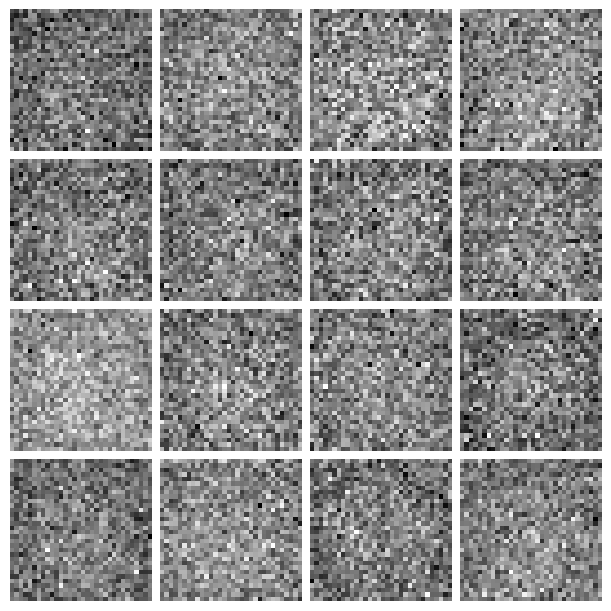

In [ ]:
#| eval: false
show_images(s[:16], imsize=1.5)

In [ ]:
#| eval: false
clearn = TrainLearner(model, DataLoaders([],[(s,yb)]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)
feats2,y2 = clearn.capture_preds()
feats2 = feats2.float().squeeze()
feats2.shape

torch.Size([256, 512])

In [ ]:
#| eval: false
means = feats.mean(0)
means.shape

torch.Size([512])

In [ ]:
#| eval: false
covs = feats.T.cov()
covs.shape

torch.Size([512, 512])

In [ ]:
#| eval: false
s1,s2 = _calc_stats(feats),_calc_stats(feats2)

In [ ]:
#| eval: false
_calc_fid(*s1, *s2)

33.83489121216962

In [ ]:
#| eval: false
_calc_kid(feats, feats2)

0.05612194538116455

## FID class

In [0]:
#| echo: false
#| output: asis
show_doc(ImageEval)

In [ ]:
#| eval: false
ie = ImageEval(model, learn.dls, cbs=[DeviceCB()])

In [ ]:
#| eval: false

ie.fid(s)

CPU times: user 7.38 s, sys: 234 ms, total: 7.62 s
Wall time: 263 ms


33.90600362686632

In [ ]:
#| eval: false

ie.kid(s)

CPU times: user 714 ms, sys: 23 ms, total: 737 ms
Wall time: 23 ms


0.0564301423728466

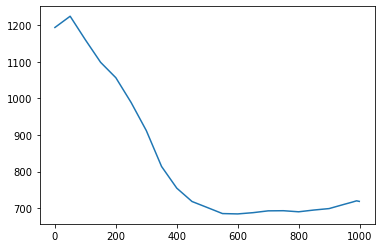

In [ ]:
#| eval: false
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.fid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

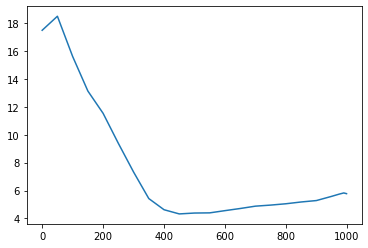

In [ ]:
#| eval: false
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.kid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

In [ ]:
#| eval: false
ie.fid(xb)

6.615052956342197

In [ ]:
#| eval: false
ie.kid(xb)

-0.02641688659787178

## Inception

In [ ]:
#| eval: false
from pytorch_fid.inception import InceptionV3

In [ ]:
#| eval: false
a = tensor([1,2,3])
a.repeat((3,1))

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [ ]:
#| eval: false
class IncepWrap(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = InceptionV3(resize_input=True)
    def forward(self, x): return self.m(x.repeat(1,3,1,1))[0]

In [ ]:
#| eval: false
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [ ]:
#| eval: false
ie = ImageEval(IncepWrap(), dls, cbs=[DeviceCB()])

In [ ]:
#| eval: false

ie.fid(s)

CPU times: user 1min 11s, sys: 1.61 s, total: 1min 13s
Wall time: 2.31 s


63.81579821823857

In [ ]:
#| eval: false
ie.fid(xb)

27.95811916882883

In [ ]:
#| eval: false

ie.kid(s)

CPU times: user 7.44 s, sys: 140 ms, total: 7.58 s
Wall time: 255 ms


0.010766863822937012

In [ ]:
#| eval: false
ie.kid(xb)

-8.697943121660501e-05